In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
loss_fct = nn.CrossEntropyLoss()

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv_norm3 = nn.BatchNorm2d(128)
        
        self.conv_drop = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(4*4*128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv_norm1(x)
        x = F.leaky_relu(x)
        x = self.conv_drop(x)
        x = F.max_pool2d(x ,2)
        
        x = self.conv2(x)
        x = self.conv_norm2(x)
        x = F.leaky_relu(x)
        x = self.conv_drop(x)
        x = F.max_pool2d(x ,2)
        
        x = self.conv3(x)
        x = self.conv_norm3(x)
        x = F.leaky_relu(x)
        x = self.conv_drop(x)
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, -1)

In [7]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]
test_correct = []

In [9]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Epoch {} ({:.0f}%) \tLoss: {:.6f}'.format(
                epoch,
                100. * batch_idx / len(train_loader), loss.item()), end="\r")
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [10]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_correct.append( 100. * correct / len(test_loader.dataset) )
    print('\nTest set --- \t Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Epoch 1 (100%) 	Loss: 1.501245
Test set --- 	 Loss: 1.5357, Accuracy: 4409/10000 (44%)

Epoch 2 (100%) 	Loss: 1.637457
Test set --- 	 Loss: 1.3820, Accuracy: 4986/10000 (50%)

Epoch 3 (100%) 	Loss: 1.387566
Test set --- 	 Loss: 1.2698, Accuracy: 5484/10000 (55%)

Epoch 4 (100%) 	Loss: 1.422052
Test set --- 	 Loss: 1.2013, Accuracy: 5649/10000 (56%)

Epoch 5 (100%) 	Loss: 1.546565
Test set --- 	 Loss: 1.1378, Accuracy: 5941/10000 (59%)

Epoch 6 (100%) 	Loss: 1.113385
Test set --- 	 Loss: 1.1094, Accuracy: 6008/10000 (60%)

Epoch 7 (100%) 	Loss: 1.295482
Test set --- 	 Loss: 1.0478, Accuracy: 6287/10000 (63%)

Epoch 8 (100%) 	Loss: 1.498943
Test set --- 	 Loss: 0.9946, Accuracy: 6435/10000 (64%)

Epoch 9 (100%) 	Loss: 1.145203
Test set --- 	 Loss: 0.9568, Accuracy: 6593/10000 (66%)

Epoch 10 (100%) 	Loss: 0.948606
Test set --- 	 Loss: 0.9699, Accuracy: 6594/10000 (66%)

Epoch 11 (100%) 	Loss: 1.220600
Test set --- 	 Loss: 0.9097, Accuracy: 6867/10000 (69%)

Epoch 12 (100%) 	Loss: 1.11742

Text(0, 0.5, 'negative log likelihood loss')

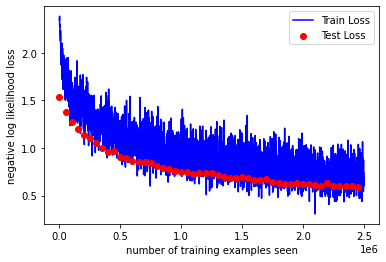

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red', zorder=10)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

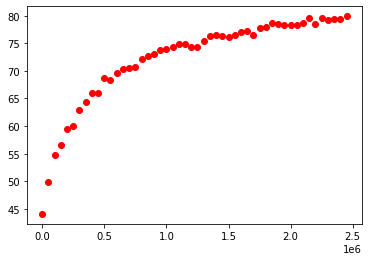

In [17]:
fig = plt.figure()
plt.scatter(test_counter, [x.cpu() for x in test_correct], color='red',)